***K-means Clustering***

**Source: https://github.com/PatWalters/practical_cheminformatics_tutorials/tree/main/clustering**

**In this notebook, we will use the K-means clustering method to identify clusters of molecules**

In [36]:
import numpy as np
import rdkit.Chem as Chem
import pandas as pd
import useful_rdkit_utils as uru
from rdkit import Chem
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import datamol as dm
import matplotlib.cm as cm

In [37]:
tqdm.pandas()
sns.set()
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

***Dataset: ~4000 SMILES of BzNSN, HBE and isoflavone derivatives molecules***

In [38]:
df_mol1 = pd.read_csv(r"./Data/123Benzothiadiazole_smiles.csv")
df_mol2 = pd.read_csv(r"./Data/homobenzylic_ethers_smiles.csv")
df_mol3=pd.read_csv(r"./Data/Isoflavone_smiles.csv")

In [39]:
print(f"Number of BzNSN (1,2,3 Benzothiadiazole) = %d, HBE (Homobenzylic Ethers) = %d, and Isoflavone = %d molecules." %(df_mol1.shape[0],df_mol2.shape[0],df_mol3.shape[0]))

Number of BzNSN (1,2,3 Benzothiadiazole) = 1569, HBE (Homobenzylic Ethers) = 1000, and Isoflavone = 1459 molecules.


In [40]:
print(df_mol1.shape)
df_mol1.head()

(1569, 1)


,SMILES
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C


In [41]:
print(df_mol2.shape)
df_mol2.head()

(1000, 1)


,SMILES
0,N#CC(c1ccccc1)C(Br)Oc1ccccc1
1,O=[N+]([O-])c1ccc(C(c2ccccc2)C(Br)Oc2ccccc2)cc1
2,CC(Oc1ccccc1)C(C#N)c1ccc(C#N)cc1
3,COC(C#N)C(C)(C)c1ccc(-c2ccccc2)cc1
4,COC(Oc1ccccc1)C(C)(C#N)c1ccc([N+](=O)[O-])cc1


In [42]:
print(df_mol3.shape)
df_mol3.head()

(1459, 1)


,SMILES
0,CC(C)C(=Cc1ccccc1-c1coc2ccccc2c1=O)C(C)C
1,CC=Cc1cccc2oc(OC(=O)CC)c(-c3ccccc3)c(=O)c12
2,CC=C(C)c1cccc2c(=O)c(-c3ccccc3)coc12
3,Cc1ccccc1-c1coc2c(C)cccc2c1=O
4,CCCCCc1cccc2c(=O)c(-c3ccccc3)coc12


In [43]:
df_mols=pd.concat([df_mol1,df_mol2,df_mol3],axis=0)
isnd=np.arange(0,df_mols.shape[0],1)
df_mols.index=isnd
print(df_mols.shape)
df_mols.head()

(4028, 1)


,SMILES
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C


In [44]:
df_mols['mol'] = df_mols.SMILES.progress_apply(Chem.MolFromSmiles)
df_mols['fp'] = df_mols.mol.progress_apply(uru.mol2morgan_fp)

100%|██████████| 4028/4028 [00:00<00:00, 10909.02it/s]


In [45]:
X = np.stack(df_mols.fp)

**X has morgan fingerprints bit vector of length 2048**

In [46]:
X.shape

(4028, 2048)

***Calculate Silhouette score to determine the appropriate number of clusters***

In [47]:
cluster_range = range(2,25)
score_list = []
for k in tqdm(cluster_range):
    km = KMeans(n_clusters=k,random_state=42)
    cluster_labels = km.fit_predict(X)
    score = silhouette_score(X,cluster_labels)
    score_list.append([k,score])

100%|██████████| 23/23 [00:54<00:00,  2.36s/it]


In [48]:
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])
score_df.head()

,K,Silhouette Score
0,2,0.151334
1,3,0.164248
2,4,0.150758
3,5,0.116377
4,6,0.111609


***Select the number of clusters that corresponds to the highest Silhouette Score***

In [49]:
score_df.iloc[score_df["Silhouette Score"].idxmax()]

K                   3.000000
Silhouette Score    0.164248
Name: 1, dtype: float64

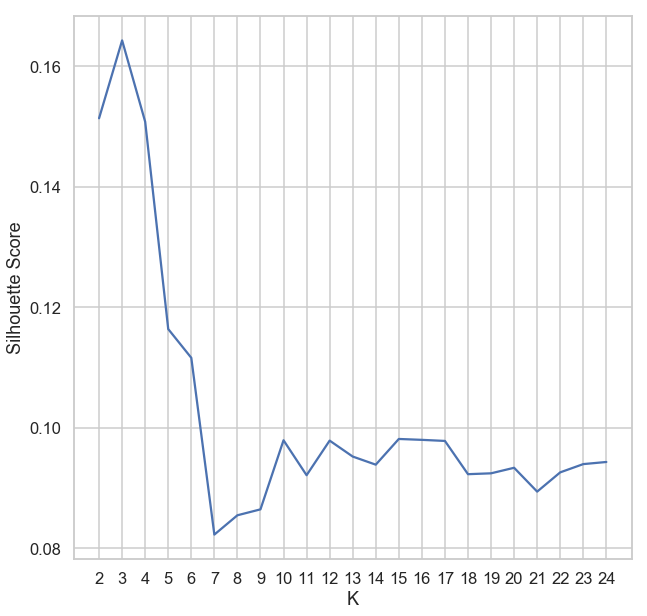

In [50]:
ax = sns.lineplot(x="K",y="Silhouette Score",data=score_df)
ax.set_xticks(cluster_range);

In [51]:
num_clusters = 3
km_opt = KMeans(n_clusters=num_clusters)
clusters_opt = km_opt.fit_predict(X)

In [52]:
def silhouette_plot(X,cluster_labels):
    """
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    sns.set_style('whitegrid')
    sample_df = pd.DataFrame(silhouette_samples(X,cluster_labels),columns=["Silhouette"])
    sample_df['Cluster'] = cluster_labels
    n_clusters = max(cluster_labels+1)
    color_list = [cm.nipy_spectral(float(i) / n_clusters) for i in range(0,n_clusters)]
    ax = sns.scatterplot()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    y_lower = 10
    unique_cluster_ids = sorted(sample_df.Cluster.unique())
    for i in unique_cluster_ids:
        cluster_df = sample_df.query('Cluster == @i')
        cluster_size = len(cluster_df)
        y_upper = y_lower + cluster_size
        ith_cluster_silhouette_values = cluster_df.sort_values("Silhouette").Silhouette.values
        color = color_list[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i),fontsize="small")
        y_lower = y_upper + 10
    ax.axvline(silhouette_avg,color="red",ls="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.set(yticklabels=[]) 
    ax.yaxis.grid(False) 

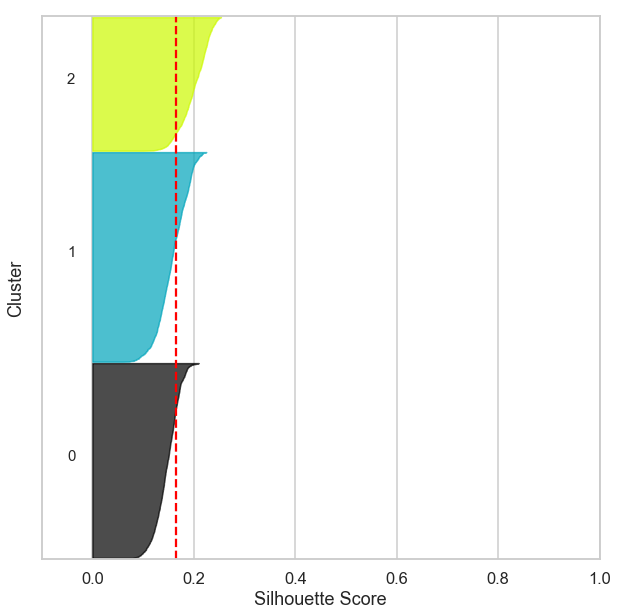

In [53]:
silhouette_plot(X,clusters_opt)

**No negative Silhouette Score means clusters are well separated from each other**

C:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


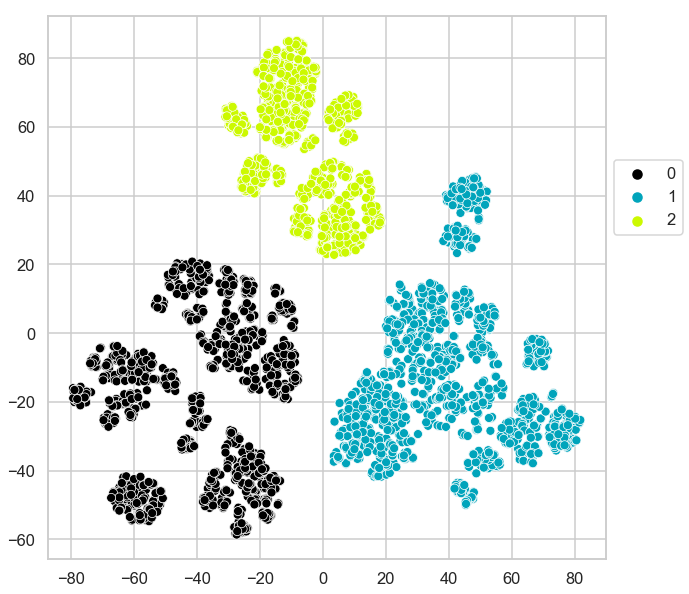

In [54]:
tsne = TSNE(n_components=2, init='pca')
crds = tsne.fit_transform(X,clusters_opt)
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=clusters_opt,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)

In [55]:
opt_cluster_df = df_mols.copy()
opt_cluster_df['Cluster'] = clusters_opt

**Visualize clusters with mols2grid**

In [56]:
import mols2grid
cluster_id = 0
cols = ["SMILES","Cluster"]
display_df = opt_cluster_df[cols].query("Cluster == @cluster_id")
print(display_df.shape)
mols2grid.display(display_df,subset=["img"],n_cols=5,size=(320,240))

(1459, 2)


In [57]:
cluster_id = 1
cols = ["SMILES","Cluster"]
display_df = opt_cluster_df[cols].query("Cluster == @cluster_id")
print(display_df.shape)
mols2grid.display(display_df,subset=["img"],n_cols=5,size=(320,240))

(1569, 2)


In [58]:
cluster_id = 2
cols = ["SMILES","Cluster"]
display_df = opt_cluster_df[cols].query("Cluster == @cluster_id")
print(display_df.shape)
mols2grid.display(display_df,subset=["img"],n_cols=5,size=(320,240))

(1000, 2)


***K-means clustering algorithm is able to distinguish between BzNSN (1,2,3 Benzothiadiazole), HBE (Homobenzylic Ethers) and Isoflavone molecules.***

**Visualize Clusters with datamol**

In [60]:
print("Number of molecules in Cluster 1: ",opt_cluster_df[opt_cluster_df["Cluster"]==0].shape[0])
print("Number of molecules in Cluster 2: ",opt_cluster_df[opt_cluster_df["Cluster"]==1].shape[0])
print("Number of molecules in Cluster 3: ",opt_cluster_df[opt_cluster_df["Cluster"]==2].shape[0])

Number of molecules in Cluster 1:  1459
Number of molecules in Cluster 2:  1569
Number of molecules in Cluster 3:  1000


In [61]:
print(f"Number of BzNSN (1,2,3 Benzothiadiazole) = %d, HBE (Homobenzylic Ethers) = %d, and Isoflavone = %d molecules." %(df_mol1.shape[0],df_mol2.shape[0],df_mol3.shape[0]))

Number of BzNSN (1,2,3 Benzothiadiazole) = 1569, HBE (Homobenzylic Ethers) = 1000, and Isoflavone = 1459 molecules.


***Cluster 1 Molecules***

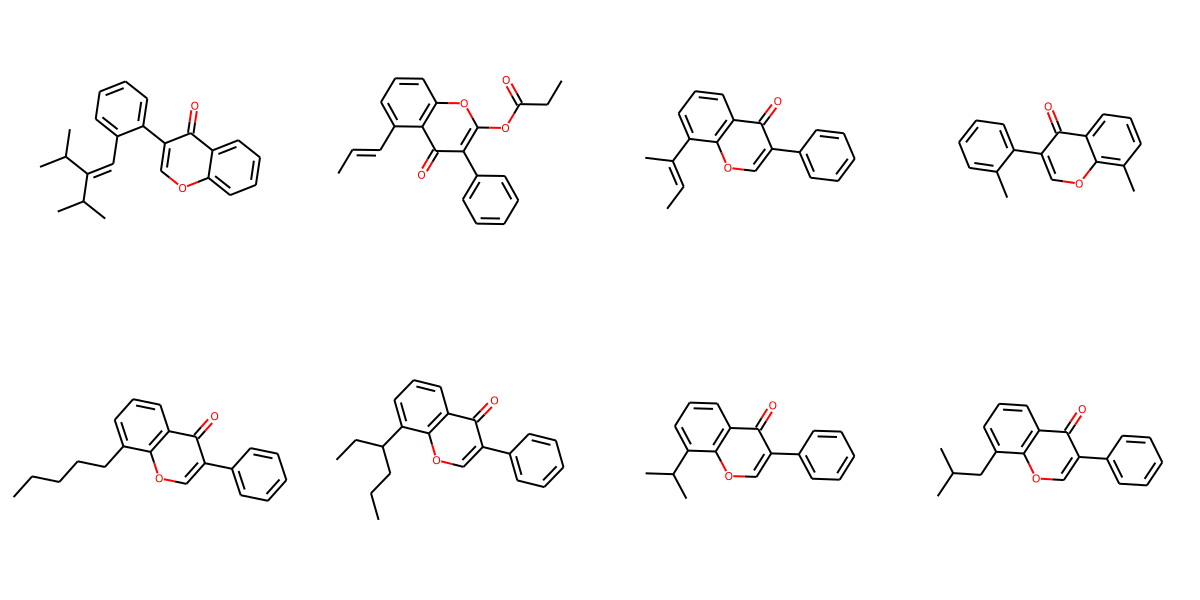

In [71]:
dm.to_image(opt_cluster_df[opt_cluster_df["Cluster"]==0]["mol"].to_list()[:8])

***Cluster 2 Molecules***

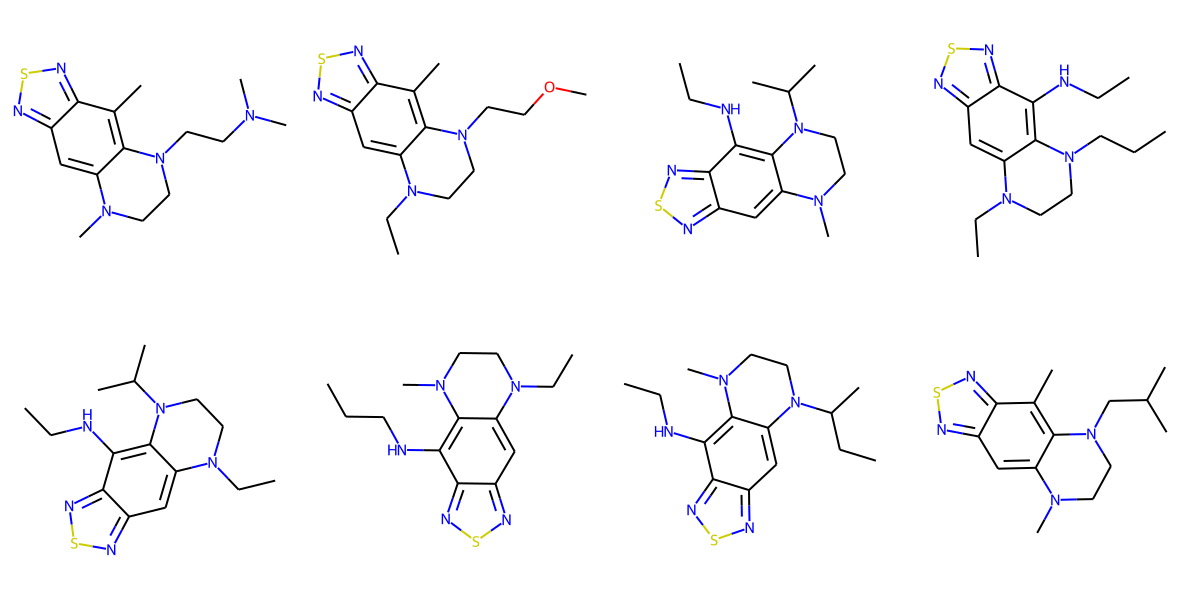

In [72]:
dm.to_image(opt_cluster_df[opt_cluster_df["Cluster"]==1]["mol"].to_list()[:8])

***Cluster 3 Molecules***

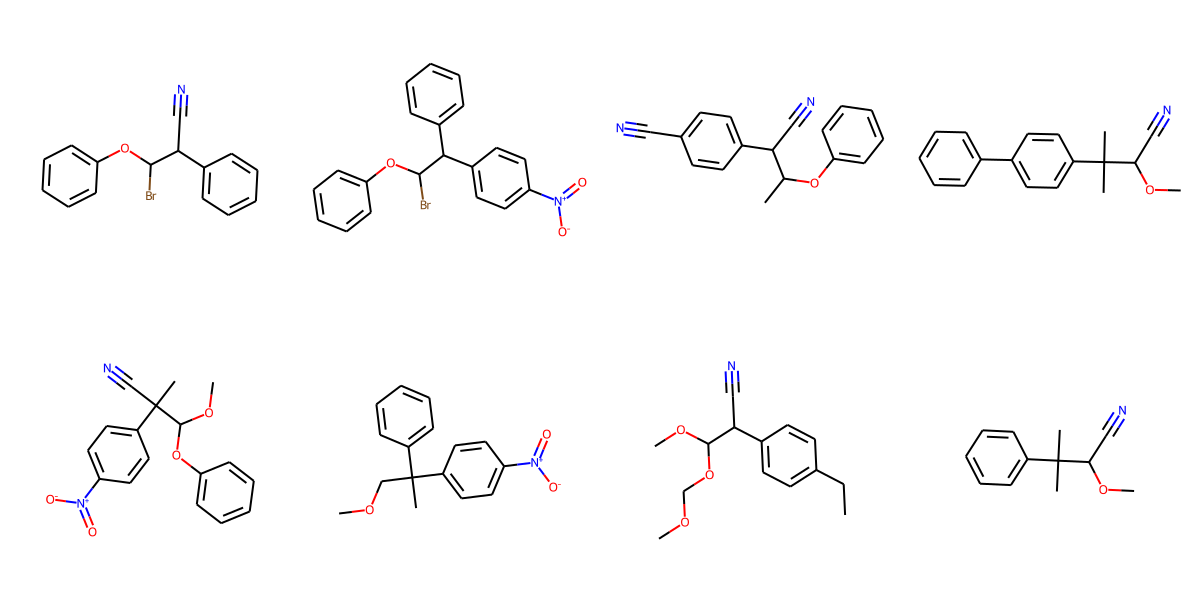

In [73]:
dm.to_image(opt_cluster_df[opt_cluster_df["Cluster"]==2]["mol"].to_list()[:8])